# Fouille des données Fit

## Importation des librairies

In [1]:
import xmltodict
import json
import pandas
import matplotlib
import numpy as np
np.set_printoptions(threshold=10000,suppress=True)
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import pandas
import matplotlib.pyplot as plt
import re
import datetime
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler
import csv

## Activité hebdomadaire

### Lecture du fichier

Afin de faciliter le parsing des données, nous les convertissons au format "json"

Ci-dessous, une fonction qui prend en entér un fichier csv et le convertit en fichier json

In [2]:
def csv_to_json(csvFilePath, jsonFilePath):
    jsonArray = []
      
    #read csv file
    with open(csvFilePath, encoding='utf-8') as csvf: 
        #load csv file data using csv library's dictionary reader
        csvReader = csv.DictReader(csvf) 

        #convert each csv row into python dict
        for row in csvReader: 
            #add this python dict to json array
            jsonArray.append(row)
  
    #convert python jsonArray to JSON String and write to file
    with open(jsonFilePath, 'w', encoding='utf-8') as jsonf: 
        jsonString = json.dumps(jsonArray, indent=4)
        jsonf.write(jsonString)

In [3]:
fileCsv=r'Résumés_quotidiens.csv'
fileJson=r'Res.json'
csv_to_json(fileCsv,fileJson)

Le fichier **Résumes quotidiens.csv** regroupe des données relatives à plusieurs jours. Il contient, entre autres, la date, les calories brulées, le nombre de minutes d'activité, la distance parcourue ...

In [4]:
#ouvrir le fichier json
with open('Res.json') as file:
    jsonRes= json.load(file)

### Formatage des données

Nous données ne nous informent pas du jour de semaine correspondant à chaque date, 

pour ce faire, nous exécutons le code ci-dessous:

In [5]:
#parcourir les lignes et attribuer à chaque date son jour de semaine
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
l=[]
for i in jsonRes:
    a=i['Date']
    l=a.split('-')
    intDay = datetime.date(year=int(l[0]), month=int(l[1]), day=int(l[2])).weekday()
    i['Jour']=days[intDay]

Nous récupérons uniquement les données qui nous intéressent, 

Ici, nous allons nous intéresser aux distances parcourues par jour (et aussi le nombre de pas)

In [6]:
list_jours=[]
n=0
for i in jsonRes:
    Dico_jours={}
    n=n+1
    Dico_jours['Jour']=i['Jour']
    Dico_jours['Date']=i['Date']
    try:
        Dico_jours['Distance (m)']=float(i['Distance (m)'])
    except:
        Dico_jours['Distance (m)']=0
    Dico_jours['Nombre de pas']=int(i['Nombre de pas'])
    list_jours.append(Dico_jours)
    n=n+1
#print(list_jours)

Nous transformons les données qui nous intéressent en dataframe afin que ce soit plus simple à manipuler par la suite

In [7]:
Dates = [i['Date'] for i in list_jours]
Jours = [i['Jour'] for i in list_jours]
Distances = [i['Distance (m)'] for i in list_jours]

df = pandas.DataFrame({'Jours':Jours, 'Dates':Dates, 'Distances':Distances})
#df['Heures']  = [pandas.to_datetime(i) for i in df['Heures']]


df.sort_values(by='Dates')

,Jours,Dates,Distances
0,Friday,2020-10-09,2860.575053
1,Saturday,2020-10-10,3373.796407
2,Sunday,2020-10-11,524.743626
3,Monday,2020-10-12,2339.617304
4,Tuesday,2020-10-13,1940.035948
...,...,...,...
97,Thursday,2021-01-14,3476.782690
98,Friday,2021-01-15,3332.903255
99,Saturday,2021-01-16,2729.618742
100,Sunday,2021-01-17,115.356933


<function matplotlib.pyplot.show(close=None, block=None)>

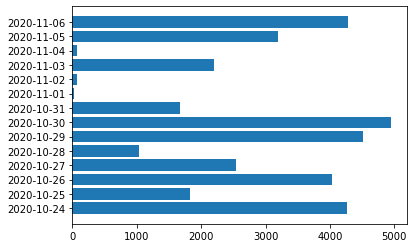

In [8]:
plt.barh(Dates[15:29], Distances[15:29])
plt.show

L'histogramme ci-dessus représente la distance parcours en fonction des jours de la semaine, sur une semaine donnée (ici sur la première semaine du fichier)

Nous pouvons remarquer que la distance parcourue change d'un jour à l'autre, ce qui est logique et représentatif de l'activité qu'un individu puisse avoir au cours d'une semaine.

### Clustering avec kmeans

Nous définissons les variables dont nous aurons besoin pour la générations des clusters

In [9]:
X=df.iloc[:,2]
labels=df.iloc[:,0]
X=np.array(X)
X = X.reshape(1,-1)

Nous appliquons ensuite l'algorithme kmeans pour générer les clusters

Nous commençons par utiliser metrics.silouette_score() afin de savoir le nombre de clusters que l'on devrait garder

In [10]:
###tester nb clusters
from sklearn import metrics
for i in np.arange(2, 4):
    clustering = cluster.KMeans(n_clusters=i).fit_predict(X.reshape(-1,1))
    print(metrics.silhouette_score(X.reshape(-1,1), clustering,metric='euclidean'))
print()

0.656006356891866
0.6598847778687352



Nous remarquons que le différence est très petite entre les deux valeurs (0.003), ça ne fait pas vraiment de différence. 

Nous décidons de garder deux clusters uniquement:

- C0: Activité importante: l'individu marche beaucoup

- C1: Activité faible: l'individu marche peu

In [10]:
kmeans = cluster.KMeans(n_clusters=2, random_state=0).fit(X.reshape(-1,1))

clustering = kmeans.labels_

print(clustering)

kmeans.cluster_centers_

[0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1
 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 0 0 0 1 1]


array([[3886.80052418],
       [ 718.3269001 ]])

Nous faisons une petite présentation graphique des deux clusters sur deux semaines (que l'on choisit)

Nous choisissons de mettre en avant **les jours de semaine**, car nous voudrions voir **quels sont les jours de la semaine l'individu marche le plus (est plus actif)**

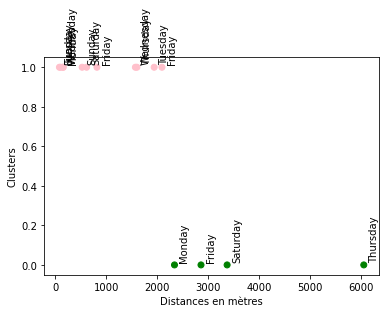

In [11]:
colors = ['green','pink']

plt.scatter(X[0,0:15], clustering[0:15], c= clustering[0:15], cmap=matplotlib.colors.ListedColormap(colors))
for label, x, y in zip(labels[0:15], X[0,0:15], clustering[0:15]):
    plt.annotate(label, xy=(x, y), xytext=(5, 5), textcoords='offset points',rotation=90)
plt.xlabel('Distances en mètres')
plt.ylabel('Clusters')
plt.show()

=> En rose, nous avons les jours où l'individu aurait le moins marché

=> En vert, nous aurons les jours où l'individu aurait le plus marché

Nous pouvons remarquer que certains jours de semaine sont présents dans les deux clusters, ce qui est normal, car en fonction des semaines, une personne pourrait avoir une activité importante ou moins importante les mêmes jours de la semaine

Exemple: Une personne *lambda* marche dans un parc chaque lundi en fin de journée
    
- Un lundi de la semaine x, la personne va marcher en fin de journée

- Un lundi de la semaine y, il pleut fort, la personne ne pourra pas aller faire son tour au parc

Afin d'avoir l'activité **hebdomadaire type** d'une personne, nous généralisons tout cela,

C'est pourquoi nous allons compter le nombre d'occurences de chaque jour de la semaine dans le cluster_0(*marche_importante*) et dans le cluster_1(*marche_faible*)


In [12]:
dfc=pandas.DataFrame(clustering)
dfc.rename(columns = {0: 'clusters'}, inplace = True)
dfc
mydf=pandas.concat([df, dfc], axis=1)
mydf

,Jours,Dates,Distances,clusters
0,Friday,2020-10-09,2860.575053,0
1,Saturday,2020-10-10,3373.796407,0
2,Sunday,2020-10-11,524.743626,1
3,Monday,2020-10-12,2339.617304,0
4,Tuesday,2020-10-13,1940.035948,1
...,...,...,...,...
97,Thursday,2021-01-14,3476.782690,0
98,Friday,2021-01-15,3332.903255,0
99,Saturday,2021-01-16,2729.618742,0
100,Sunday,2021-01-17,115.356933,1


In [13]:
gliste=[]
days=['Monday', 'Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
clusters=[0, 1]

for c in clusters:
    pliste=[]
    for d in days:
        compteur=0
        for i in mydf.values:
            if((i[0]== d) and (i[3]==c)):
                compteur=compteur+1
        pliste.append(compteur)
    gliste.append(pliste)

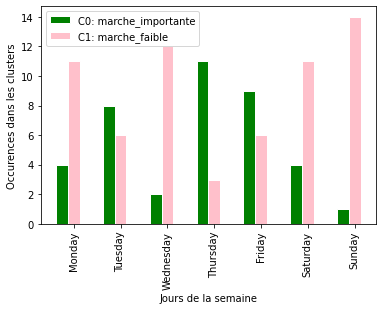

In [14]:
barWidth = 0.25
 
c0=gliste[0]
c1=gliste[1]
# Set position of bar on X axis
r1 = np.arange(len(c0))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, c0, color='green', width=barWidth, edgecolor='white', label='C0: marche_importante')
plt.bar(r2, c1, color='pink', width=barWidth, edgecolor='white', label='C1: marche_faible')
 
# Add xticks on the middle of the group bars
plt.xlabel('Jours de la semaine')
plt.ylabel("Occurences dans les clusters")
plt.xticks([r + barWidth for r in range(len(c0))], days, rotation=90)
plt.legend()
plt.show()

Ce graphique nous informe sur le jours de la semaine où l'activité est plus importante ainsi que ceux où l'activité est plutôt faible

## Activité quotidienne

Dans cette partie, nous allons nous intéresser à l'activité quotidienne

Pour ce faire, nous allons étudier l'activité pour un jour de chacun des clusters précédants


### Jour du cluster C0

In [15]:
csvFilePath0 = r'2020-11-12.csv'
jsonFilePath0 = r'2020-11-12.json'
csv_to_json(csvFilePath0, jsonFilePath0)
#ce jour correspond à un jeudi

In [16]:
with open('2020-11-12.json') as file:
    jsonData= json.load(file)
#print(jsonData)

### Formatage des données

Pour faciliter l'analyse, nous ne gardons que les lignes où la distance n'est pas nulle/inexistante

In [17]:
lis=[]
for i in jsonData:
    Dico={}
    if (i['Distance (m)']!=''):
        Dico['Heure_debut']=i['Heure de début']
        Dico['Heure_fin']=i['Heure de fin']
        Dico['Distance (m)']=float(i['Distance (m)'])
        Dico['Nombre de pas']=i['Nombre de pas']
        lis.append(Dico)
#print(lis)

In [18]:
Heures = [i['Heure_debut'] for i in lis]
Distances = [i['Distance (m)'] for i in lis]

df = pandas.DataFrame({'Heures':Heures, 'Distances':Distances})
#df['Heures']  = [pandas.to_datetime(i) for i in df['Heures']]


df.sort_values(by='Heures')

,Heures,Distances
0,16:30:00.000+01:00,273.045769
1,16:45:00.000+01:00,47.684713
2,17:00:00.000+01:00,113.140490
3,17:15:00.000+01:00,452.974030
4,17:30:00.000+01:00,389.078837
5,18:15:00.000+01:00,165.971411
6,18:30:00.000+01:00,275.641584
7,18:45:00.000+01:00,22.120937
8,19:00:00.000+01:00,53.209824
9,19:15:00.000+01:00,267.008545


Nous représentons cela avec un histogramme afin de voir à quelles heures l'activité est plus importantes, et de l'ordre de combien est-elle

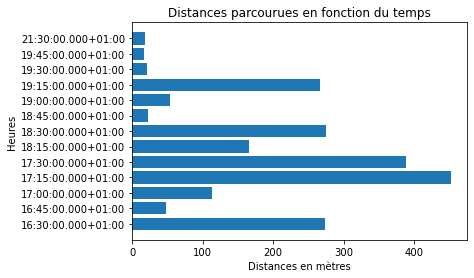

In [19]:
plt.barh(Heures, Distances)
plt.ylabel('Heures')
plt.xlabel('Distances en mètres')
plt.title('Distances parcourues en fonction du temps')
plt.show()

### Jour du cluster C1

In [20]:
csvFilePath1 = r'2020-10-11.csv'
jsonFilePath1 = r'2020-10-11.json'
csv_to_json(csvFilePath1, jsonFilePath1)
#ce jour correspond à un dimanche

In [21]:
with open('2020-10-11.json') as file:
    jsonData1= json.load(file)
#print(jsonData1)
lis1=[]
for i in jsonData1:
    Dico={}
    if (i['Distance (m)']!=''):
        Dico['Heure_debut']=i['Heure de début']
        Dico['Heure_fin']=i['Heure de fin']
        Dico['Distance (m)']=float(i['Distance (m)'])
        Dico['Nombre de pas']=i['Nombre de pas']
        lis1.append(Dico)
#print(lis1)

In [22]:
Heures = [i['Heure_debut'] for i in lis1]
Distances = [i['Distance (m)'] for i in lis1]

df1 = pandas.DataFrame({'Heures':Heures, 'Distances':Distances})


df1.sort_values(by='Heures')

,Heures,Distances
0,02:45:00.000+02:00,18.201735
1,12:45:00.000+02:00,23.222902
2,14:00:00.000+02:00,15.063505
3,15:45:00.000+02:00,15.605419
4,16:00:00.000+02:00,12.011007
5,17:15:00.000+02:00,22.595257
6,19:15:00.000+02:00,28.244071
7,20:30:00.000+02:00,16.946444
8,22:00:00.000+02:00,81.842722
9,22:15:00.000+02:00,236.923694


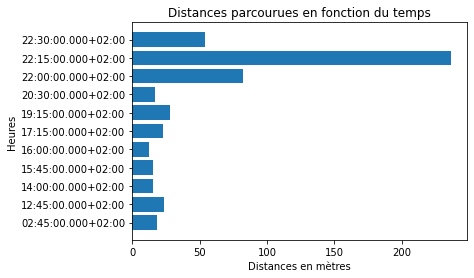

In [23]:
plt.barh(Heures, Distances)
plt.ylabel('Heures')
plt.xlabel('Distances en mètres')
plt.title('Distances parcourues en fonction du temps')
plt.show()

Nous remarquons qu'en effet, les heures et la distance différent entre les deux jours sélectionnés

Ceci pourrait nous informer sur l'activité de l'individu

Il serait logique que les heures d'activité un jour de semaine soient celles où l'individu part au travail, s'il y va à pied par exemple)
Quant aux jours correspondant au weekend, les horaires seraient différents et la distance aussi. L'activité pourrait être moins importante si l'on est chez soi et qu'on ne sorte que pour prendre l'air ou faire des courses à côté.

## Activité et localisation

In [24]:
%load_ext autotime
import pandas as pd

import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import matplotlib.pyplot as plt
import plotly_express as px
import tqdm
from tqdm import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
import csv

time: 576 ms (started: 2021-01-31 16:23:12 +01:00)


### Lecture du fichier et formatage des données

In [25]:
fileCsv=r'Résumés_quotidiens.csv'
fileJson=r'Res_gps.json'
csv_to_json(fileCsv,fileJson)

time: 10.8 ms (started: 2021-01-31 16:23:13 +01:00)


In [26]:
#ouvrir le fichier json
with open('Res_gps.json') as file:
    datagps= json.load(file)

time: 4.02 ms (started: 2021-01-31 16:23:14 +01:00)


In [27]:
#datagps

time: 543 µs (started: 2021-01-31 16:23:14 +01:00)


In [28]:
listgps=[]
for i in datagps:
    xy=[]
    if (i['Basse latitude (°)']!=''):
        xy=[i['Basse latitude (°)'],i['Basse longitude (°)'],'']
        listgps.append(xy)
#listgps

time: 1.04 ms (started: 2021-01-31 16:23:15 +01:00)


### Génération des adresses 

In [29]:
for i in listgps:
    locator = Nominatim(user_agent="myGeocoder")
    coordinates = i[0],i[1]
    location = locator.reverse(coordinates)
    i[2]=location.address

time: 27.9 s (started: 2021-01-31 16:23:16 +01:00)


In [30]:
#listgps

time: 595 µs (started: 2021-01-31 16:23:44 +01:00)


In [31]:
import os 
import folium
from folium import plugins
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import earthpy as et

# Import data from EarthPy
data = et.data.get_data('colorado-flood')

# Set working directory to earth-analytics
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

time: 501 ms (started: 2021-01-31 16:23:44 +01:00)


### Créaction d'un map

In [33]:
# Create a map using the Map() and the first coordinates of the list
m = folium.Map(location=[listgps[0][0],listgps[0][1]])

# Display the map
m

time: 14.1 ms (started: 2021-01-31 16:25:40 +01:00)


### Positionnement des marqueurs d'adresses

In [34]:
for i in listgps:    
    folium.Marker(
        location=[i[0], i[1]], # coordinates for the marker (Earth Lab at CU Boulder)
        popup= i[2], # pop-up label for the marker
        icon=folium.Icon()
    ).add_to(m)


m

time: 164 ms (started: 2021-01-31 16:25:43 +01:00)
